# BERT model - text sentiment analyzer

In [176]:
from transformers import (
    BertTokenizer, BertForSequenceClassification,
    RobertaTokenizer, RobertaForSequenceClassification,
    DistilBertTokenizer, DistilBertForSequenceClassification
)
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.nn.utils.rnn import pad_sequence
import torch
from utils.text_datasets import get_basic_tweet_sentiment_dataset, get_poem_sentiment_dataset, get_advanced_tweet_sentiment_dataset_only_text
import tqdm
from sklearn.model_selection import train_test_split
from utils.metrics import get_metrics, display_clasification_metrics

In [177]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Parameters

In [178]:
params = {"train_size":0.9,
"bert_unfrozen_layers":12,
"batch_size":16,
"epochs":10,
"learning_rate":2e-5,
"class_num":4,
"max_length_token":128,
"model_bert":"bert-base-uncased"}
# "model_bert":"roberta-base"}
# "model_bert":"distilbert-base-uncased"}

## Tokenizer Setup

In [179]:
tokenizer = BertTokenizer.from_pretrained(params["model_bert"])

In [162]:
tokenizer = RobertaTokenizer.from_pretrained(params["model_bert"])

In [ ]:
tokenizer = DistilBertTokenizer.from_pretrained(params["model_bert"])

In [180]:
def tokenize_function_bert(text):
    encoding = tokenizer(
        text,
        padding=False,
        truncation=True,
        max_length=params["max_length_token"],
        return_tensors=None
    )
    return torch.tensor(encoding["input_ids"])


def pad_collate_bert(batch):
    input_ids, labels = zip(*batch)
    attention_masks = []

    padded_input_ids = pad_sequence(input_ids, batch_first=True, padding_value=tokenizer.pad_token_id)
    for ids in input_ids:
        mask = torch.ones(len(ids), dtype=torch.long)
        attention_masks.append(mask)
    padded_attention_mask = pad_sequence(attention_masks, batch_first=True, padding_value=0)
    
    return {
        "input_ids": padded_input_ids,
        "attention_mask": padded_attention_mask,
        "labels": torch.tensor(labels)
    }

## Data Preparation

In [182]:
train_dataset, validation_dataset, test_dataset = get_poem_sentiment_dataset(tokenize_function_bert)

In [166]:
train_dataset, test_dataset = get_basic_tweet_sentiment_dataset(tokenize_function_bert)
train_dataset, validation_dataset = train_test_split(
    train_dataset, train_size=params["train_size"], shuffle=True
)

In [ ]:
train_dataset, test_dataset = get_advanced_tweet_sentiment_dataset_only_text(tokenize_function_bert)
train_dataset, validation_dataset = train_test_split(
    train_dataset, train_size=params["train_size"], shuffle=True
)

In [183]:
class_num = params["class_num"]
dataset_labels = list(range(class_num))

In [184]:
train_loader = DataLoader(train_dataset, batch_size=params["batch_size"], shuffle=True, collate_fn=pad_collate_bert)
validation_loader = DataLoader(validation_dataset, batch_size=params["batch_size"], shuffle=False, collate_fn=pad_collate_bert)
test_loader = DataLoader(test_dataset, batch_size=params["batch_size"], shuffle=False, collate_fn=pad_collate_bert)

In [185]:
def freeze_transformer_layers(model, num_unfrozen_layers):
    if hasattr(model, 'bert'):
        encoder_layers = model.bert.encoder.layer
    elif hasattr(model, 'roberta'):
        encoder_layers = model.roberta.encoder.layer
    elif hasattr(model, 'distilbert'):
        encoder_layers = model.distilbert.transformer.layer
    else:
        raise ValueError("Model nie zawiera znanych bloków: 'bert', 'roberta', ani 'distilbert'.")

    total_layers = len(encoder_layers)

    for i, layer in enumerate(encoder_layers):
        if i < total_layers - num_unfrozen_layers:
            for param in layer.parameters():
                param.requires_grad = False

    return model


## Model

In [186]:
model = BertForSequenceClassification.from_pretrained(params["model_bert"], num_labels=params["class_num"]).to(device)

/home/dominika/.local/share/virtualenvs/app-LDMNNxfo/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [172]:
model = RobertaForSequenceClassification.from_pretrained(params["model_bert"], num_labels=params["class_num"]).to(device)

In [ ]:
model = DistilBertForSequenceClassification.from_pretrained(params["model_bert"], num_labels=params["class_num"]).to(device)

In [187]:
model = freeze_transformer_layers(model, num_unfrozen_layers=params["bert_unfrozen_layers"])

optimizer = torch.optim.Adam(model.parameters(), lr=params["learning_rate"])
loss_fun = CrossEntropyLoss()

## Training

In [188]:
model.train()
progress_bar = tqdm.tqdm(range(params["epochs"]), desc="Epoch")

for epoch in progress_bar:
    total_loss = 0
    batches = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)
        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        batches += 1

    model.eval()
    with torch.no_grad():
        val_loss = 0
        val_batches = 0
        for batch in validation_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            val_loss += outputs.loss.item()
            val_batches += 1

    model.train()
    progress_bar.set_postfix({
        "Train loss": total_loss / batches,
        "Validation loss": val_loss / val_batches
    })

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]/home/dominika/Pulpit/NLP-2025/utils/text_datasets.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.tokinizer(self.text[idx])), torch.tensor(
Epoch: 100%|██████████| 10/10 [13:45<00:00, 82.57s/it, Train loss=0.0103, Validation loss=0.495]


## Measure model

In [189]:
def measure_model(model, data_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return all_labels, all_preds

Train set metrics


/home/dominika/Pulpit/NLP-2025/utils/text_datasets.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.tokinizer(self.text[idx])), torch.tensor(


F1 Score 1.0
Accuracy 1.0
Recall 1.0

Validation set metrics


/home/dominika/Pulpit/NLP-2025/utils/text_datasets.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.tokinizer(self.text[idx])), torch.tensor(
/home/dominika/.local/share/virtualenvs/app-LDMNNxfo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


F1 Score 0.6258408408408409
Accuracy 0.8857142857142857
Recall 0.5877080809440481

Test set metrics


/home/dominika/Pulpit/NLP-2025/utils/text_datasets.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.tokinizer(self.text[idx])), torch.tensor(


F1 Score 0.5944198953155002
Accuracy 0.8365384615384616
Recall 0.5782561022120518


/home/dominika/.local/share/virtualenvs/app-LDMNNxfo/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


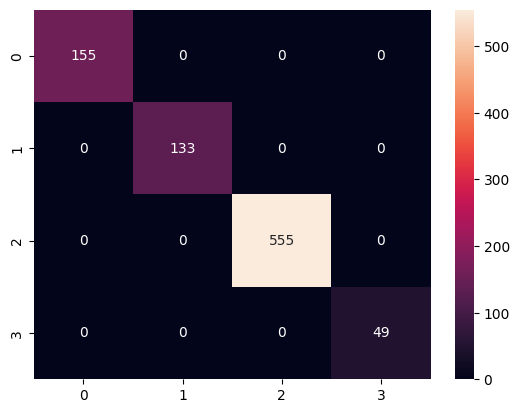

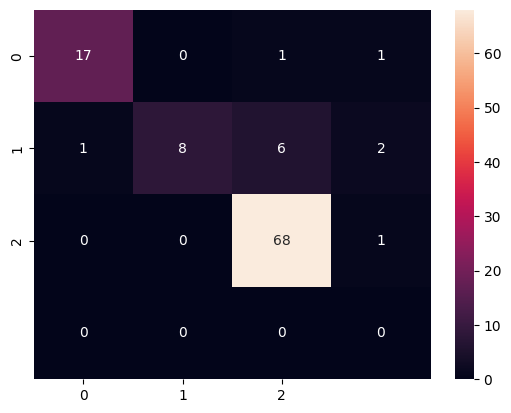

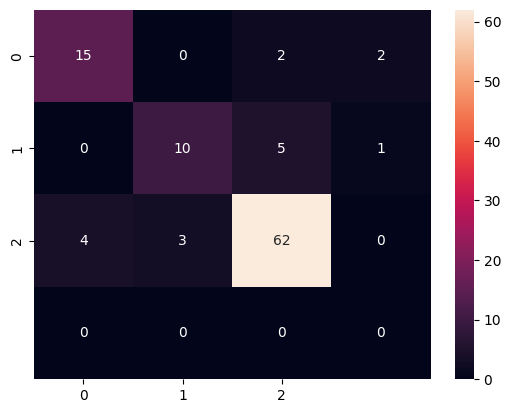

In [191]:
print("Train set metrics")
train_labels, train_preds = measure_model(model, train_loader)
train_preds_tensor = torch.tensor(train_preds)
train_labels_tensor = torch.tensor(train_labels)

display_clasification_metrics(train_preds_tensor, train_labels_tensor, labels=dataset_labels)
plt.figure()

print("\nValidation set metrics")
val_labels, val_preds = measure_model(model, validation_loader)
val_preds_tensor = torch.tensor(val_preds)
val_labels_tensor = torch.tensor(val_labels)

display_clasification_metrics(val_preds_tensor, val_labels_tensor, labels=dataset_labels)
plt.figure()

print("\nTest set metrics")
test_labels, test_preds = measure_model(model, test_loader)
test_preds_tensor = torch.tensor(test_preds)
test_labels_tensor = torch.tensor(test_labels)

display_clasification_metrics(test_preds_tensor, test_labels_tensor, labels=dataset_labels)